Total injected: 160773, total recovered: 57472

Found 323 TIC folders in the working directory.
Found 325 TOIs matching the TIC folders.
Using 310 detected planets for occurrence calculation.
Calculation complete.


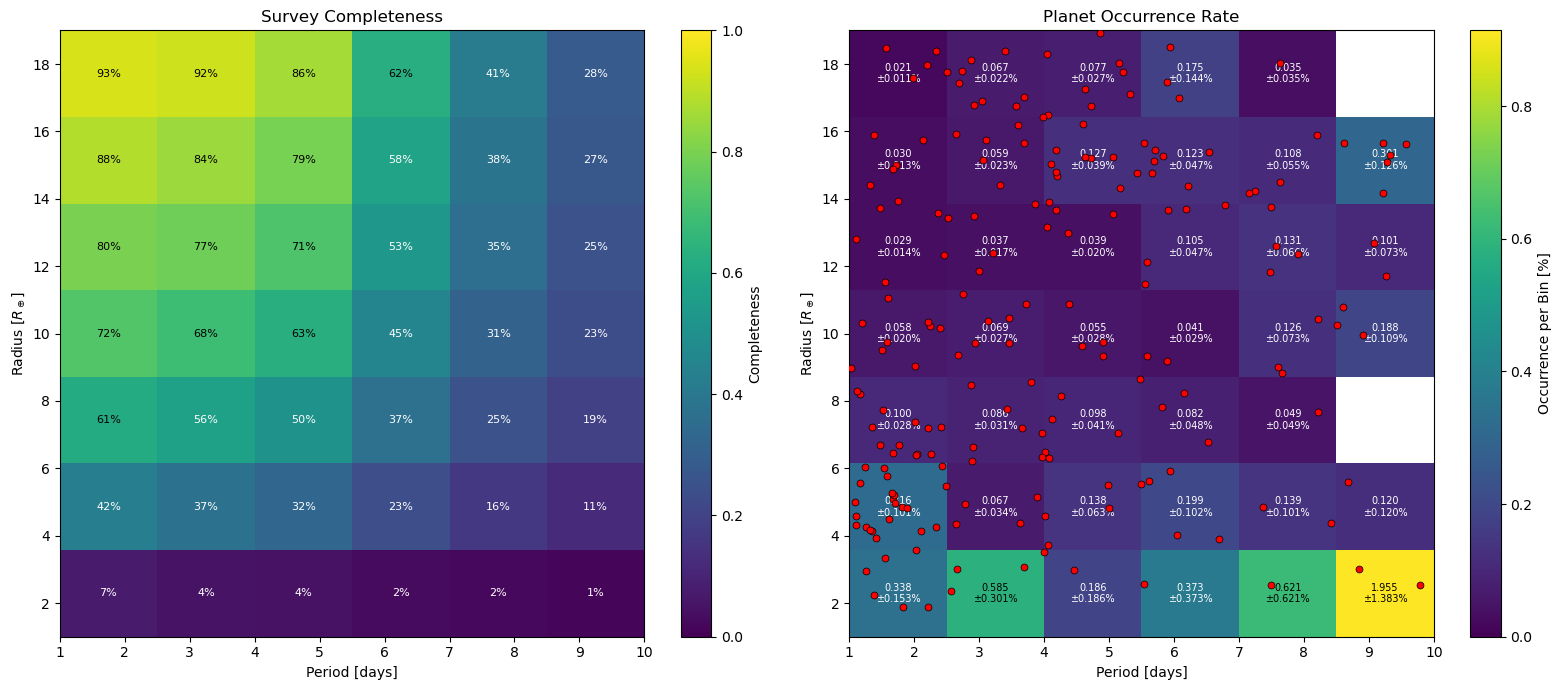


--- SUMMARY ---
Total detected planets used in calculation: 310

Global occurrence (P=1-10d, R=1-19R⊕): 7.556% (±1.650%)
Earth-size (1-3 R⊕) occurrence (P=1-10d): 4.058% (±1.608%)


In [26]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.constants import G, R_sun, M_sun
import warnings

# Ignore common warnings from pandas and numpy for cleaner output
warnings.filterwarnings('ignore')

# ---------------- USER / BINNING SETTINGS ----------------
# Bins for period (1-10 days, 9 linear-spaced bins)
period_edges = np.linspace(1, 10, 7)
# Bins for radius (1-19 R_earth, 9 linear-spaced bins)
radius_edges = np.linspace(1, 19, 8)

# Calculate bin centers for annotations using arithmetic mean for linear bins
P_centers = (period_edges[:-1] + period_edges[1:]) / 2.0
R_centers = (radius_edges[:-1] + radius_edges[1:]) / 2.0

np_bins = len(P_centers)
nr_bins = len(R_centers)

# Total number of stars in the survey
N_stars = 73107

# ---------------- DATA LOADING & PREPARATION ----------------
# Initialize accumulators for injection/recovery data
total_injected = np.zeros((np_bins, nr_bins), dtype=int)
recovered_injected = np.zeros((np_bins, nr_bins), dtype=int)
sum_geometric_factor = np.zeros((np_bins, nr_bins), dtype=float)

# Dictionary to store parameters for each star
star_params = {}

root = '.'
folders = [f for f in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, f))]

# Loop through each star's directory to gather injection data
for d in folders:
    params_path = os.path.join(d, 'params_star.csv')
    inj_path = os.path.join(d, 'a_tls_report_per_run.csv')
    if not (os.path.isfile(params_path) and os.path.isfile(inj_path)):
        continue
    try:
        params = pd.read_csv(params_path)
        df = pd.read_csv(inj_path)
        
        # Ensure required columns are present
        if not {'R_star', 'M_star'}.issubset(params.columns) or \
           not {'period', 'radius', 'found'}.issubset(df.columns):
            continue

        # Store stellar parameters in SI units
        Rstar_m = float(params['R_star'].iloc[0]) * R_sun.value
        Mstar_kg = float(params['M_star'].iloc[0]) * M_sun.value
        star_params[d] = {'R_m': Rstar_m, 'M_kg': Mstar_kg}

        # Process injection data
        df['found_bool'] = df['found'].astype(str).str.upper().isin(['TRUE', 'T', '1', 'YES'])
        H_inj = np.histogram2d(df['period'], df['radius'], bins=[period_edges, radius_edges])[0].astype(int)
        H_rec = np.histogram2d(df.loc[df['found_bool'], 'period'], df.loc[df['found_bool'], 'radius'], bins=[period_edges, radius_edges])[0].astype(int)
        
        total_injected += H_inj
        recovered_injected += H_rec

        # Accumulate geometric transit probability factor (R_star / a)
        for i, P_center in enumerate(P_centers):
            P_sec = P_center * 86400.0
            a_m = ((G.value * Mstar_kg * P_sec**2) / (4.0 * np.pi**2))**(1.0/3.0)
            p_geo = Rstar_m / a_m
            sum_geometric_factor[i, :] += H_inj[i, :] * p_geo
            
    except Exception as e:
        print(f"  - Warning: Could not process folder '{d}'. Error: {e}")
        continue

# ---------------- COMPLETENESS CALCULATION ----------------
completeness = np.zeros_like(sum_geometric_factor)
completeness_err = np.zeros_like(sum_geometric_factor)
mask_inj = total_injected > 0
completeness[mask_inj] = recovered_injected[mask_inj] / total_injected[mask_inj]
completeness_err[mask_inj] = np.sqrt(completeness[mask_inj] * (1.0 - completeness[mask_inj]) / total_injected[mask_inj])
print(f"Total injected: {total_injected.sum()}, total recovered: {recovered_injected.sum()}")

# ---------------- TOI & DETECTED PLANET PREPARATION ----------------
def extract_tic_ids(folder_names):
    mapping = {}
    for folder in folder_names:
        m = re.match(r"TIC(\d+)", folder, re.IGNORECASE)
        if m:
            mapping[int(m.group(1))] = folder
    return mapping

tic_to_folder = extract_tic_ids(folders)
print(f"\nFound {len(tic_to_folder)} TIC folders in the working directory.")

# Load TOIs from the external CSV file
tois_fn = 'tois.csv'
if not os.path.isfile(tois_fn):
    raise FileNotFoundError("ERROR: 'tois.csv' not found. Please place a TOI catalog in the working directory.")

tois = pd.read_csv(tois_fn, comment='#')
# Find column names for TIC ID, period, and radius
tic_col = next((c for c in tois.columns if 'tic' in c.lower()), None)
p_col = next((c for c in tois.columns if 'period' in c.lower()), None)
r_col = next((c for c in tois.columns if 'radius' in c.lower()), None)

if not all([tic_col, p_col, r_col]):
    raise KeyError("Could not find required columns (TIC ID, Period, Radius) in 'tois.csv'.")

# Filter TOIs to match only the stars in our survey
tois[tic_col] = pd.to_numeric(tois[tic_col], errors='coerce')
matched = tois[tois[tic_col].isin(list(tic_to_folder.keys()))].copy()
print(f"Found {len(matched)} TOIs matching the TIC folders.")

# Prepare the final detected planets dataframe
matched['star_dir'] = matched[tic_col].map(tic_to_folder)
detected_planets = matched.rename(columns={p_col: 'period', r_col: 'radius'})
detected_planets['R_m'] = detected_planets['star_dir'].map(lambda d: star_params.get(d, {}).get('R_m'))
detected_planets['M_kg'] = detected_planets['star_dir'].map(lambda d: star_params.get(d, {}).get('M_kg'))
detected_planets.dropna(subset=['star_dir', 'period', 'radius', 'R_m', 'M_kg'], inplace=True)
detected_planets.reset_index(drop=True, inplace=True)


if len(detected_planets) == 0:
    raise ValueError("No valid detected planets remained after matching with star parameters. Cannot calculate occurrence.")
print(f"Using {len(detected_planets)} detected planets for occurrence calculation.")

# ---------------- OCCURRENCE CALCULATION ----------------
occurrence = np.zeros_like(sum_geometric_factor)
occurrence_err = np.zeros_like(sum_geometric_factor)
sum_weights = np.zeros_like(sum_geometric_factor)
sum_weights_sq = np.zeros_like(sum_geometric_factor)

# Digitize planets into bins
p_idx = np.digitize(detected_planets['period'].values, period_edges) - 1
r_idx = np.digitize(detected_planets['radius'].values, radius_edges) - 1

# Calculate weights for each detected planet
for k, planet in detected_planets.iterrows():
    i, j = p_idx[k], r_idx[k]
    # Ensure the planet is within our defined grid
    if not (0 <= i < np_bins and 0 <= j < nr_bins):
        continue

    # Get completeness for the planet's bin
    C = completeness[i, j]
    if C <= 0:
        continue # Cannot correct for planets in bins with zero completeness

    # Calculate geometric transit probability for this specific planet
    P_sec = planet['period'] * 86400.0
    a_m = ((G.value * planet['M_kg'] * P_sec**2) / (4.0 * np.pi**2))**(1.0/3.0)
    p_tr = planet['R_m'] / a_m
    if p_tr <= 0:
        continue

    # Calculate the Petigura weight and add to sums
    weight = 1.0 / (p_tr * C)
    sum_weights[i, j] += weight
    sum_weights_sq[i, j] += weight**2

# Calculate final occurrence rate and error per bin
occurrence = sum_weights / N_stars
occurrence_err = np.sqrt(sum_weights_sq) / N_stars

# Convert to percentages for plotting and reporting
occurrence_percent = occurrence * 100.0
occurrence_err_percent = occurrence_err * 100.0
print("Calculation complete.")

# ---------------- PLOTTING ----------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
X, Y = np.meshgrid(period_edges, radius_edges)

# --- Plot 1: Survey Completeness ---
completeness_plot = np.ma.array(completeness.T, mask=(total_injected.T == 0))
pcm1 = ax1.pcolormesh(X, Y, completeness_plot, shading='auto', cmap='viridis', vmin=0, vmax=1)
fig.colorbar(pcm1, ax=ax1, label='Completeness')
ax1.set_title('Survey Completeness')
for i, px in enumerate(P_centers):
    for j, ry in enumerate(R_centers):
        if total_injected[i, j] > 0:
            comp_pct = int(completeness[i, j] * 100)
            ax1.text(px, ry, f'{comp_pct}%', ha='center', va='center', fontsize=8,
                     color='white' if 0.0 < completeness[i,j] < 0.6 else 'black')

# --- Plot 2: Petigura-Style Planet Occurrence Rate ---
# Create a mask for cells with low completeness (<1%)
mask_low_completeness = (completeness.T < 0.01)

# Mask the occurrence data where no planets were found
occurrence_plot = np.ma.array(occurrence_percent.T, mask=(occurrence_percent.T == 0))

# Calculate vmax based only on data that will be colored to avoid washing out the scale
valid_occ_for_vmax = occurrence_percent[completeness >= 0.01]
vmax = np.nanpercentile(valid_occ_for_vmax[valid_occ_for_vmax > 0], 98) if np.any(valid_occ_for_vmax > 0) else 1.0

# Plot the occurrence rate with the 'viridis' colormap
pcm2 = ax2.pcolormesh(X, Y, occurrence_plot, shading='auto', cmap='viridis', vmin=0, vmax=vmax)
fig.colorbar(pcm2, ax=ax2, label='Occurrence per Bin [%]')

# Overlay a white color on cells with low completeness
white_cmap = plt.cm.colors.ListedColormap(['white'])
ax2.pcolormesh(X, Y, np.ma.masked_where(~mask_low_completeness, mask_low_completeness),
               cmap=white_cmap, alpha=1.0, shading='auto')

# Filter planets to only those within the plot's boundaries
planets_in_range = detected_planets[
    (detected_planets['period'] >= period_edges.min()) &
    (detected_planets['period'] <= period_edges.max()) &
    (detected_planets['radius'] >= radius_edges.min()) &
    (detected_planets['radius'] <= radius_edges.max())
]

# Overlay the detected planets as red dots
ax2.scatter(planets_in_range['period'], planets_in_range['radius'],
            s=25, c='red', marker='o', edgecolor='black', lw=0.5,
            label='Detected Planets', zorder=10) # zorder ensures dots are on top

ax2.set_title('Planet Occurrence Rate')

# Annotate the plot with occurrence values
for i, px in enumerate(P_centers):
    for j, ry in enumerate(R_centers):
        # Annotate any bin that has a calculated occurrence rate
        if occurrence_percent[i, j] > 0:
            val = occurrence_percent[i, j]
            err = occurrence_err_percent[i, j]
            txt = f'{val:.3f}\n±{err:.3f}%'
            
            # Determine text color based on the background
            if completeness[i, j] < 0.01:
                # The background is white, so text must be black
                text_color = 'black'
            else:
                # The background is colored by viridis. For dark background (low values), use white text.
                # For light background (high values, e.g., yellow), use black text for contrast.
                text_color = 'black' if val > vmax * 0.5 else 'white'
                
            ax2.text(px, ry, txt, ha='center', va='center', fontsize=7, color=text_color)

for ax in [ax1, ax2]:
    ax.set_xlabel('Period [days]')
    ax.set_ylabel('Radius [$R_\\oplus$]')

plt.tight_layout()
plt.show()

# ---------------- SUMMARY STATISTICS ----------------
print('\n--- SUMMARY ---')
print(f'Total detected planets used in calculation: {len(detected_planets)}')
total_occ = np.sum(occurrence_percent)
total_err = np.sqrt(np.sum(occurrence_err_percent**2))
print(f'\nGlobal occurrence (P=1-10d, R=1-19R⊕): {total_occ:.3f}% (±{total_err:.3f}%)')

# Earth-size planet occurrence
rmask = (R_centers >= 1.0) & (R_centers <= 3.0)
earth_occ = np.sum(occurrence_percent[:, rmask])
earth_err = np.sqrt(np.sum(occurrence_err_percent[:, rmask]**2))
print(f'Earth-size (1-3 R⊕) occurrence (P=1-10d): {earth_occ:.3f}% (±{earth_err:.3f}%)')

In [28]:
# ---------------- SAVE PLOTS SEPARATELY ----------------
# Save completeness plot
fig1, ax1 = plt.subplots(figsize=(8, 6))
completeness_plot = np.ma.array(completeness.T, mask=(total_injected.T == 0))
pcm1 = ax1.pcolormesh(X, Y, completeness_plot, shading='auto', cmap='viridis', vmin=0, vmax=1)
fig1.colorbar(pcm1, ax=ax1, label='Completeness')
ax1.set_title('Survey Completeness')
for i, px in enumerate(P_centers):
    for j, ry in enumerate(R_centers):
        if total_injected[i, j] > 0:
            comp_pct = int(completeness[i, j] * 100)
            ax1.text(px, ry, f'{comp_pct}%', ha='center', va='center', fontsize=8,
                     color='white' if 0.0 < completeness[i, j] < 0.6 else 'black')
ax1.set_xlabel('Period [days]')
ax1.set_ylabel('Radius [$R_\\oplus$]')
fig1.tight_layout()
fig1.savefig("survey_completeness_1.png", dpi=400)   # high resolution save
plt.close(fig1)

# Save occurrence plot
fig2, ax2 = plt.subplots(figsize=(8, 6))
occurrence_plot = np.ma.array(occurrence_percent.T, mask=(occurrence_percent.T == 0))
pcm2 = ax2.pcolormesh(X, Y, occurrence_plot, shading='auto', cmap='viridis', vmin=0, vmax=vmax)
fig2.colorbar(pcm2, ax=ax2, label='Occurrence per Bin [%]')
ax2.set_title('Planet Occurrence Rate')
ax2.scatter(planets_in_range['period'], planets_in_range['radius'],
            s=25, c='red', marker='o', edgecolor='black', lw=0.5, label='Detected Planets')

for i, px in enumerate(P_centers):
    for j, ry in enumerate(R_centers):
        if occurrence_percent[i, j] > 0:
            val = occurrence_percent[i, j]
            err = occurrence_err_percent[i, j]
            txt = f'{val:.3f}\n±{err:.3f}%'
            if completeness[i, j] < 0.01:
                text_color = 'black'
            else:
                text_color = 'black' if val > vmax * 0.5 else 'white'
            ax2.text(px, ry, txt, ha='center', va='center', fontsize=7, color=text_color)

ax2.set_xlabel('Period [days]')
ax2.set_ylabel('Radius [$R_\\oplus$]')
fig2.tight_layout()
fig2.savefig("planet_occurrence_1.png", dpi=400)   # high resolution save
plt.close(fig2)

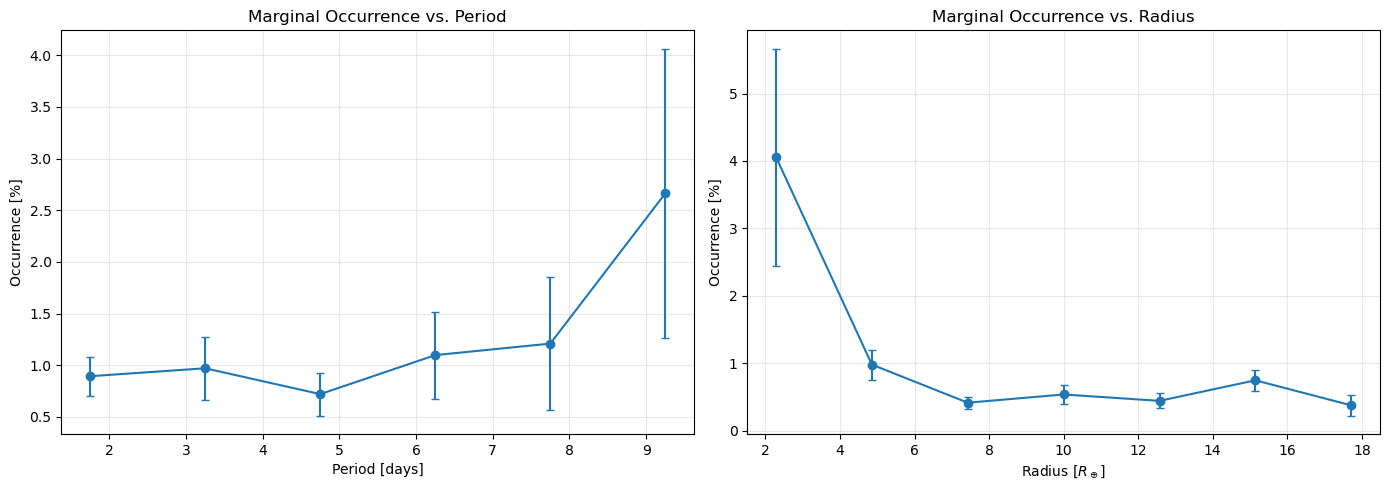

In [19]:
# ---------------- MARGINAL DISTRIBUTIONS ----------------
# Sum over radius to get occurrence vs period
occ_vs_period = np.sum(occurrence, axis=1) * 100.0  # in %
err_vs_period = np.sqrt(np.sum(occurrence_err**2, axis=1)) * 100.0

# Sum over period to get occurrence vs radius
occ_vs_radius = np.sum(occurrence, axis=0) * 100.0  # in %
err_vs_radius = np.sqrt(np.sum(occurrence_err**2, axis=0)) * 100.0

fig, (axP, axR) = plt.subplots(1, 2, figsize=(14, 5))

# --- Occurrence vs Period ---
axP.errorbar(P_centers, occ_vs_period, yerr=err_vs_period, fmt='o-', capsize=3)
axP.set_xlabel('Period [days]')
axP.set_ylabel('Occurrence [%]')
axP.set_title('Marginal Occurrence vs. Period')
axP.grid(True, alpha=0.3)

# --- Occurrence vs Radius ---
axR.errorbar(R_centers, occ_vs_radius, yerr=err_vs_radius, fmt='o-', capsize=3)
axR.set_xlabel('Radius [$R_\\oplus$]')
axR.set_ylabel('Occurrence [%]')
axR.set_title('Marginal Occurrence vs. Radius')
axR.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("marginals_1.png", dpi=400)
plt.show()


--- SANITY CHECK ---
Total actual detected planets: 310
Total observed (from histogram): 203
Total expected (sum over cells): 221.59 ± 19.05

Observed vs Expected counts by Period bin:
  Period bin centered 1.75d: Obs=65.0, Exp=75.38 ± 12.06
  Period bin centered 3.25d: Obs=44.0, Exp=43.42 ± 6.66
  Period bin centered 4.75d: Obs=39.0, Exp=38.97 ± 6.33
  Period bin centered 6.25d: Obs=25.0, Exp=33.43 ± 10.06
  Period bin centered 7.75d: Obs=16.0, Exp=16.08 ± 4.08
  Period bin centered 9.25d: Obs=14.0, Exp=14.31 ± 3.88

Observed vs Expected counts by Radius bin:
  Radius bin centered 2.29R⊕: Obs=14.0, Exp=15.25 ± 4.13
  Radius bin centered 4.86R⊕: Obs=39.0, Exp=47.04 ± 10.63
  Radius bin centered 7.43R⊕: Obs=31.0, Exp=31.00 ± 5.66
  Radius bin centered 10.00R⊕: Obs=28.0, Exp=29.07 ± 5.58
  Radius bin centered 12.57R⊕: Obs=25.0, Exp=24.11 ± 4.93
  Radius bin centered 15.14R⊕: Obs=41.0, Exp=41.74 ± 6.65
  Radius bin centered 17.71R⊕: Obs=25.0, Exp=33.39 ± 10.05


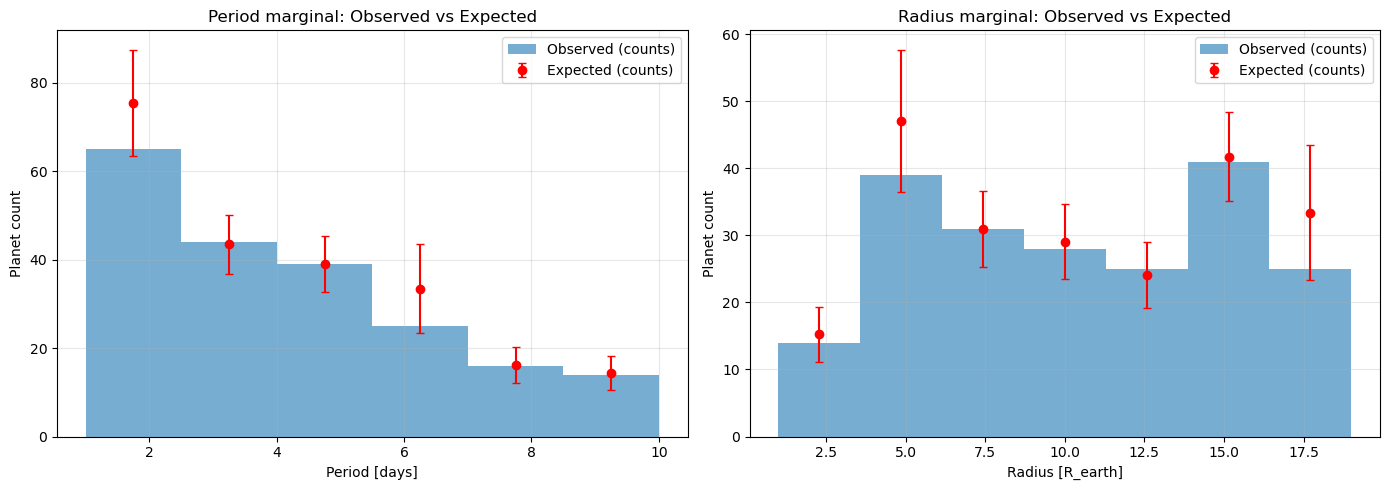

In [21]:
# ---------------- MARGINALS + PER-CELL TRANSIT PROB (EXPECTED COUNTS) + SANITY CHECK ----------------
# Compute per-cell average geometric transit probability from accumulators
p_geo = np.zeros_like(sum_geometric_factor)
mask = total_injected > 0
p_geo[mask] = sum_geometric_factor[mask] / total_injected[mask]
p_geo = np.minimum(p_geo, 1.0)  # clip for safety

# Expected detected planets per cell: occurrence (per star) * N_stars * p_geo * completeness
Nexp_cell = occurrence * N_stars * p_geo * completeness
Nexp_err_cell = occurrence_err * N_stars * p_geo * completeness

# Observed counts per cell (2D histogram of detected planets)
pH2d, _, _ = np.histogram2d(detected_planets['period'], detected_planets['radius'], bins=[period_edges, radius_edges])

obs_period = pH2d.sum(axis=1)
obs_radius = pH2d.sum(axis=0)

exp_period = Nexp_cell.sum(axis=1)
exp_period_err = np.sqrt((Nexp_err_cell**2).sum(axis=1))
exp_radius = Nexp_cell.sum(axis=0)
exp_radius_err = np.sqrt((Nexp_err_cell**2).sum(axis=0))

# ---------------- SANITY CHECK PRINTS ----------------
print("\n--- SANITY CHECK ---")
print(f"Total actual detected planets: {len(detected_planets)}")
print(f"Total observed (from histogram): {int(pH2d.sum())}")
print(f"Total expected (sum over cells): {Nexp_cell.sum():.2f} ± {np.sqrt((Nexp_err_cell**2).sum()):.2f}")

print("\nObserved vs Expected counts by Period bin:")
for i, P in enumerate(P_centers):
    print(f"  Period bin centered {P:.2f}d: Obs={obs_period[i]}, Exp={exp_period[i]:.2f} ± {exp_period_err[i]:.2f}")

print("\nObserved vs Expected counts by Radius bin:")
for j, R in enumerate(R_centers):
    print(f"  Radius bin centered {R:.2f}R⊕: Obs={obs_radius[j]}, Exp={exp_radius[j]:.2f} ± {exp_radius_err[j]:.2f}")

# ---------------- PLOTTING ----------------
fig, (axP, axR) = plt.subplots(1, 2, figsize=(14, 5))

# Period marginal
widths_p = np.diff(period_edges)
axP.bar(P_centers, obs_period, width=widths_p, align='center', alpha=0.6, label='Observed (counts)')
axP.errorbar(P_centers, exp_period, yerr=exp_period_err, fmt='o', color='red', capsize=3, label='Expected (counts)')
axP.set_xlabel('Period [days]')
axP.set_ylabel('Planet count')
axP.set_title('Period marginal: Observed vs Expected')
axP.legend()
axP.grid(alpha=0.3)

# Radius marginal
widths_r = np.diff(radius_edges)
axR.bar(R_centers, obs_radius, width=widths_r, align='center', alpha=0.6, label='Observed (counts)')
axR.errorbar(R_centers, exp_radius, yerr=exp_radius_err, fmt='o', color='red', capsize=3, label='Expected (counts)')
axR.set_xlabel('Radius [R_earth]')
axR.set_ylabel('Planet count')
axR.set_title('Radius marginal: Observed vs Expected')
axR.legend()
axR.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("expectaion_1.png", dpi=400)
plt.show()

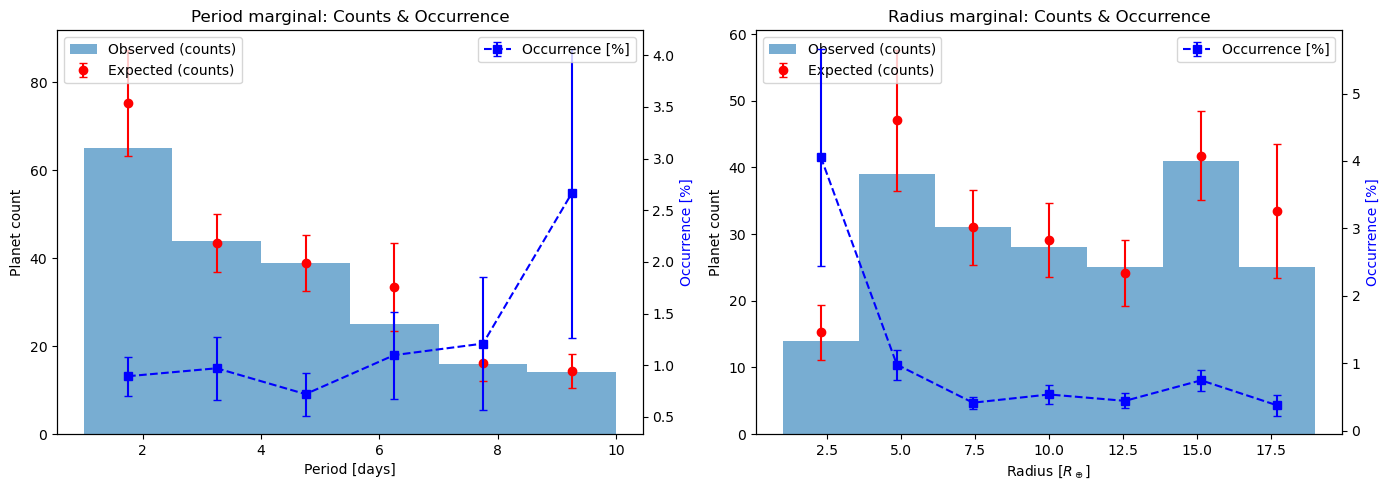

Total observed (from histogram): 203
Total expected (sum over cells): 221.59 ± 19.05


In [23]:
# ---------------- MARGINALS + EXPECTED + OCCURRENCE ----------------
# Compute per-cell average geometric transit probability from accumulators
p_geo = np.zeros_like(sum_geometric_factor)
mask = total_injected > 0
p_geo[mask] = sum_geometric_factor[mask] / total_injected[mask]
p_geo = np.minimum(p_geo, 1.0)

Nexp_cell = occurrence * N_stars * p_geo * completeness
Nexp_err_cell = occurrence_err * N_stars * p_geo * completeness

pH2d, _, _ = np.histogram2d(detected_planets['period'], detected_planets['radius'], bins=[period_edges, radius_edges])
obs_period = pH2d.sum(axis=1)
obs_radius = pH2d.sum(axis=0)

exp_period = Nexp_cell.sum(axis=1)
exp_period_err = np.sqrt((Nexp_err_cell**2).sum(axis=1))
exp_radius = Nexp_cell.sum(axis=0)
exp_radius_err = np.sqrt((Nexp_err_cell**2).sum(axis=0))

# Marginal occurrence
occ_vs_period = np.sum(occurrence, axis=1) * 100.0
err_vs_period = np.sqrt(np.sum(occurrence_err**2, axis=1)) * 100.0
occ_vs_radius = np.sum(occurrence, axis=0) * 100.0
err_vs_radius = np.sqrt(np.sum(occurrence_err**2, axis=0)) * 100.0

# ---------------- PLOTTING ----------------
fig, (axP, axR) = plt.subplots(1, 2, figsize=(14, 5))

# Period marginal: observed vs expected counts + occurrence
widths_p = np.diff(period_edges)
axP.bar(P_centers, obs_period, width=widths_p, align='center', alpha=0.6, label='Observed (counts)')
axP.errorbar(P_centers, exp_period, yerr=exp_period_err, fmt='o', color='red', capsize=3, label='Expected (counts)')
axP2 = axP.twinx()
axP2.errorbar(P_centers, occ_vs_period, yerr=err_vs_period, fmt='s--', color='blue', capsize=3, label='Occurrence [%]')
axP.set_xlabel('Period [days]')
axP.set_ylabel('Planet count')
axP2.set_ylabel('Occurrence [%]', color='blue')
axP.set_title('Period marginal: Counts & Occurrence')
axP.legend(loc='upper left')
axP2.legend(loc='upper right')

# Radius marginal: observed vs expected counts + occurrence
widths_r = np.diff(radius_edges)
axR.bar(R_centers, obs_radius, width=widths_r, align='center', alpha=0.6, label='Observed (counts)')
axR.errorbar(R_centers, exp_radius, yerr=exp_radius_err, fmt='o', color='red', capsize=3, label='Expected (counts)')
axR2 = axR.twinx()
axR2.errorbar(R_centers, occ_vs_radius, yerr=err_vs_radius, fmt='s--', color='blue', capsize=3, label='Occurrence [%]')
axR.set_xlabel('Radius [$R_\\oplus$]')
axR.set_ylabel('Planet count')
axR2.set_ylabel('Occurrence [%]', color='blue')
axR.set_title('Radius marginal: Counts & Occurrence')
axR.legend(loc='upper left')
axR2.legend(loc='upper right')

plt.tight_layout()
plt.savefig("comp_1.png", dpi=400)
plt.show()

# ---------------- SANITY PRINT ----------------
print("Total observed (from histogram):", int(pH2d.sum()))
print("Total expected (sum over cells): %.2f ± %.2f" % (Nexp_cell.sum(), np.sqrt((Nexp_err_cell**2).sum())))